In [134]:
from pathlib import Path  
from matplotlib import pyplot as plot
from pathlib import Path  
import pandas as pandas
import numpy as numpy
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [135]:
dataframe = pandas.read_csv("dataset.csv").dropna()
feature_names = ["Appliances","T1","RH_1","T2","RH_2","T3","RH_3","T4","RH_4","T5","RH_5","T6","RH_6","T7","RH_7","T8","RH_8","T9","RH_9","T_out","Press_mm_hg","RH_out","Windspeed","Visibility","Tdewpoint"]
dataframe = dataframe[feature_names]

X = dataframe.drop("Appliances", axis = 1)
y = dataframe["Appliances"]
TEST_SIZE_RATIO = (1 / 3)
RANDOM_STATE_SEED = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE_RATIO, random_state=RANDOM_STATE_SEED)

In [136]:
GBR_GRAPH_METRICS_DATASET_PATH = Path("./GBR_graph_metrics_dataset.csv")
if not(GBR_GRAPH_METRICS_DATASET_PATH.exists() and GBR_GRAPH_METRICS_DATASET_PATH.is_file()):
    performance = {}
    N_ESTIMATORS = 10000
    for max_depth_iterator in [1, 2, 3]:
        print("max_depth: %d" %max_depth_iterator)
        performance[max_depth_iterator] = [0] * N_ESTIMATORS
        gradient_boosting_regressor = GradientBoostingRegressor(learning_rate = 0.1, n_estimators = N_ESTIMATORS, max_depth = max_depth_iterator, verbose = 1)
        gradient_boosting_regressor.fit(X_train, y_train)
        for ilteration, y_pred in enumerate(gradient_boosting_regressor.staged_predict(X)):
            performance[max_depth_iterator][ilteration] = gradient_boosting_regressor.loss_(y, y_pred)

    csv_string = "\"max_depth\",\"iteration\",\"training_loss\""
    for depth in performance.keys():
        for iteration in numpy.arange(len(performance[depth])):
            csv_string = csv_string + "\n" + str(depth) + "," + str(iteration) + "," + str(performance[depth][iteration])
    gradient_boosted_graph_metrics_dataset = open(GBR_GRAPH_METRICS_DATASET_PATH.name, "w")
    gradient_boosted_graph_metrics_dataset.write(csv_string)
    gradient_boosted_graph_metrics_dataset.close()

max_depth: 1
      Iter       Train Loss   Remaining Time 
         1       10489.5386            4.23m
         2       10450.7376            4.24m
         3       10419.3088            4.22m
         4       10391.1226            4.21m
         5       10365.7311            4.19m
         6       10344.3734            4.19m
         7       10323.5500            4.18m
         8       10304.3883            4.18m
         9       10286.5598            4.19m
        10       10269.6979            4.19m
        20       10133.3963            4.19m
        30       10037.7359            4.18m
        40        9959.4346            4.18m
        50        9891.3821            4.20m
        60        9830.9951            4.20m
        70        9775.0576            4.19m
        80        9723.6733            4.22m
        90        9675.5107            4.22m
       100        9631.0072            4.21m
       200        9292.3991            4.12m
       300        9063.8431            4.

/Users/pru/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)


max_depth: 2
      Iter       Train Loss   Remaining Time 
         1       10455.8118            8.09m
         2       10388.4873            8.10m
         3       10325.5813            8.08m
         4       10273.1993            8.07m
         5       10211.2256            8.07m
         6       10165.2152            8.07m
         7       10125.5981            8.06m
         8       10087.9786            8.06m
         9       10042.8762            8.06m
        10       10007.2427            8.05m
        20        9685.3691            8.04m
        30        9451.5161            8.58m
        40        9214.6167            8.43m
        50        9024.9122            8.34m
        60        8840.4425            8.28m
        70        8664.4662            8.23m
        80        8508.1589            8.19m
        90        8366.9174            8.16m
       100        8249.3157            8.17m
       200        7498.2697            7.98m
       300        6964.0439            7.

/Users/pru/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)


max_depth: 3
      Iter       Train Loss   Remaining Time 
         1       10413.6652           11.99m
         2       10276.6920           11.94m
         3       10145.5788           11.93m
         4       10018.7340           11.93m
         5        9942.2516           11.93m
         6        9836.9757           11.95m
         7        9745.0890           11.95m
         8        9674.6543           11.95m
         9        9609.5284           11.96m
        10        9515.0288           11.96m
        20        8901.2323           11.92m
        30        8509.9656           11.91m
        40        8210.1529           11.89m
        50        7948.7686           11.88m
        60        7682.1708           11.86m
        70        7469.6261           11.84m
        80        7264.3983           11.83m
        90        7080.5830           11.81m
       100        6947.8993           11.80m
       200        5839.7874           11.68m
       300        5142.3405           11.

/Users/pru/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)


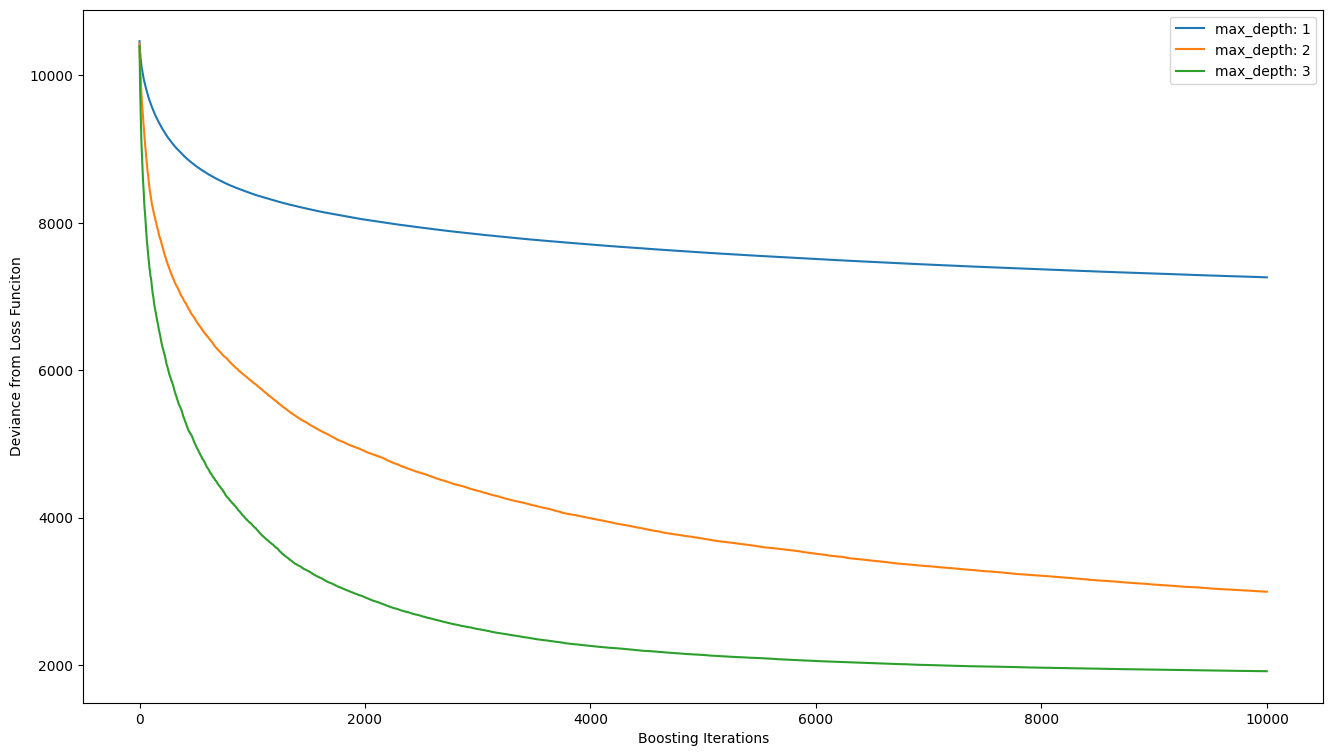

In [137]:
gbr_metrics = pandas.read_csv(GBR_GRAPH_METRICS_DATASET_PATH.name)
plot.figure(figsize=(16,9))
plot.xlabel('Boosting Iterations')
plot.ylabel('Deviance from Loss Funciton')
for depth in gbr_metrics["max_depth"].unique():
    performance = gbr_metrics.where(gbr_metrics["max_depth"] == depth).dropna()
    plot.plot(performance["iteration"], performance["training_loss"], label = "max_depth: "  + str(depth))
plot.legend(loc='upper right')
plot.savefig("GBR_deviation_vs_ilteration_for_multiple_max_depth.png")
plot.show()